# Import Library

In [34]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
#plt.rcParams['figure.figsize'] = 12, 10
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product
from datetime import datetime

import numpy as np
import seaborn as sns
from pandas.tools.plotting import autocorrelation_plot

from datetime import datetime
from collections import Counter
import re

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pyramid.arima import auto_arima


from sklearn.metrics import mean_squared_error as mse
pd.options.mode.chained_assignment = None

# Import and Check Data

In [2]:
df = pd.read_csv('tute1.csv')
df.head(3)

,Unnamed: 0,Sales,AdBudget,GDP
0,Mar-81,1020.2,659.2,251.8
1,Jun-81,889.2,589.0,290.9
2,Sep-81,795.0,512.5,290.8


# Change Dataset Format

In [3]:
#Convert object to DATETIME
df["Month_toInt"] = list(map(lambda x: datetime.strptime(x, '%b-%y').strftime('%m-%Y'), df["Unnamed: 0"]))
sr = pd.to_datetime(df['Month_toInt'])
df['Month'] = pd.DataFrame(sr)
df = df.drop(['Unnamed: 0','Month_toInt', 'AdBudget', 'GDP'], axis=1)
df = df.set_index('Month')
df.head()

,Sales
Month,
1981-03-01,1020.2
1981-06-01,889.2
1981-09-01,795.0
1981-12-01,1003.9
1982-03-01,1057.7


# Check Stationarity

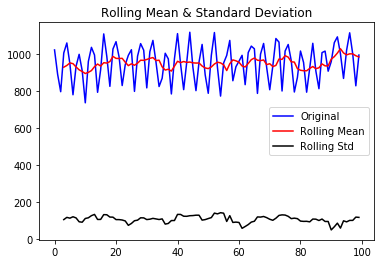

ADF Stastistic: -3.262755
p-value: 0.016628
The graph is non stationery
Critical values:
	1%: -3.505
	5%: -2.894
	10%: -2.584


In [10]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=4,center=False).mean()
    rolstd = x.rolling(window=4,center=False).std()
    
    #Plot rolling statistics:
    orig = plt.plot(x.values, color='blue',label='Original')
    mean = plt.plot(rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
test_stationarity(df['Sales'])

# Log Data

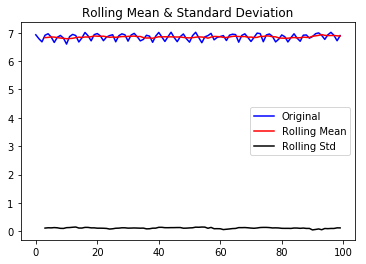

ADF Stastistic: -2.944119
p-value: 0.040453
The graph is non stationery
Critical values:
	1%: -3.504
	5%: -2.894
	10%: -2.584


In [80]:
df_log = np.log(df['Sales'])
test_stationarity(df_log)

In [23]:
df_log = pd.DataFrame(df_log, columns=['Sales'])
df_log.head()

,Sales
Month,
1981-03-01,6.927754
1981-06-01,6.790322
1981-09-01,6.678342
1981-12-01,6.911648
1982-03-01,6.963852


# Decomposition

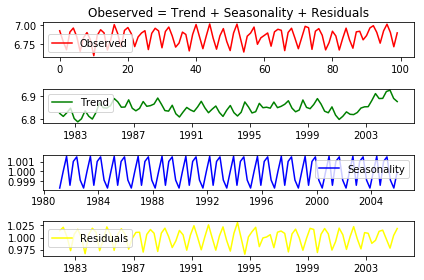

In [28]:
# Naive decomposition of our Time Series 
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_log['Sales'], model='multiplicative',freq = 7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.title('Obeserved = Trend + Seasonality + Residuals')
plt.plot(ts_log.values,label='Observed',color="red")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend',color="green")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality',color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals',color="yellow")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

-

C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


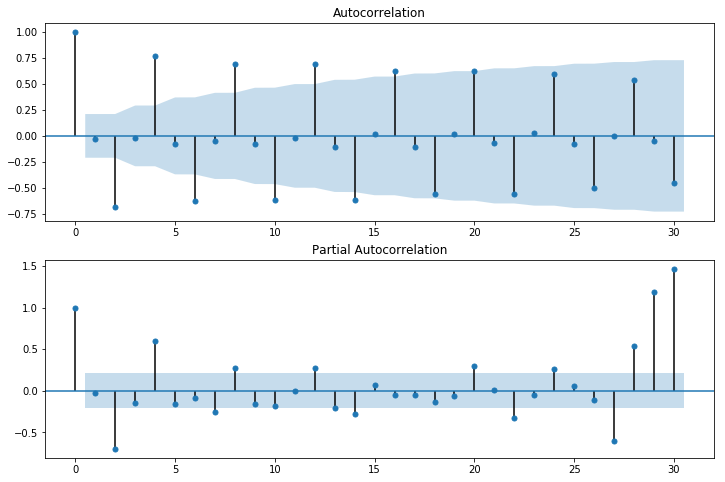

In [88]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_log['Sales'][13:].values.squeeze(), 
                         lags=30, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_log['Sales'][13:].values.squeeze(), 
                          lags=30, ax=ax);

# Split Data train test

In [90]:
train = df_log[:int(0.80*(len(df_log)))]
test = df_log[int(0.80*(len(df_log))):]
print(train.shape)
print(test.shape)

(80, 1)
(20, 1)


# Auto Arima

In [108]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warning=True)
model.fit(train)

C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-214.460, BIC=-200.168, Fit time=0.544 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-124.995, BIC=-120.231, Fit time=0.049 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-123.058, BIC=-115.912, Fit time=0.087 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-123.260, BIC=-116.114, Fit time=0.109 seconds


C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-146.962, BIC=-135.052, Fit time=1.169 seconds


C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-216.763, BIC=-200.088, Fit time=0.599 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-187.264, BIC=-172.972, Fit time=0.890 seconds
Fit ARIMA: order=(3, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=-214.397, BIC=-195.341, Fit time=0.723 seconds


C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-145.969, BIC=-134.058, Fit time=0.534 seconds


C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA: order=(4, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=-222.512, BIC=-201.074, Fit time=0.724 seconds


C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(5, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=-181.671, BIC=-157.851, Fit time=1.365 seconds


C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: order=(4, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-219.482, BIC=-200.426, Fit time=0.898 seconds


C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA: order=(4, 0, 4) seasonal_order=(0, 0, 0, 1); AIC=-187.460, BIC=-163.640, Fit time=1.182 seconds


C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(5, 0, 4) seasonal_order=(0, 0, 0, 1); AIC=-201.842, BIC=-175.640, Fit time=1.345 seconds
Total fit time: 10.239 seconds


C:\Users\tungga064185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(4, 0, 3),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend='c')

Arima Order = (4,0,3)

In [92]:
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(4, 0, 3)   Log Likelihood                 120.256
Date:                Fri, 06 Sep 2019   AIC                           -222.512
Time:                        06:17:16   BIC                           -201.074
Sample:                             0   HQIC                          -213.917
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.0744      4.876      2.271      0.023       1.519      20.630
ar.L1         -0.3462      0.203     -1.703      0.088      -0.745       0.052
ar.L2         -0.4351      0.174     -2.495      0.0

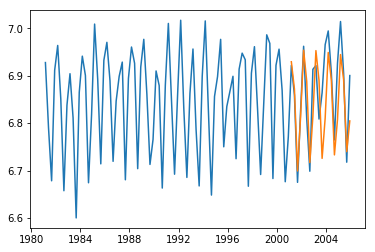

In [127]:
pred = model.predict(n_periods = len(valid))
pred = pd.DataFrame(pred, index = valid.index, columns=['Prediction'])
pred['Sales'] = df_log[int(0.80*(len(df_log))):]

plt.plot(df_log.Sales, label = 'Train')
plt.plot(forecast, label = 'Prediction')
plt.show()

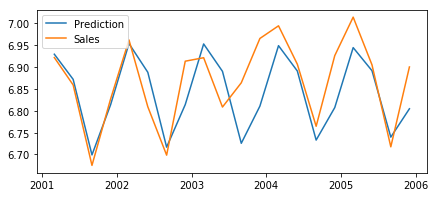

In [119]:
plt.figure(figsize=(7,3))
plt.plot(pred['Prediction'])
plt.plot(pred['Sales'])
plt.legend()
plt.show()

# Value of mape etc

In [120]:
def mapee(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))* 100

mapee(valid.Sales, forecast.Prediction)

0.7847796110724361

In [121]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.utils.validation import check_array

import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score': r2_score(y, pred),}, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [122]:
evaluate_forecast(valid, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.438934,0.05407,0.031547,0.005021,0.000081,0.78478,0.070861


# Prediksi 3 Periode

In [140]:
ramal3peropde = model.predict(n_periods = 3)
ramal3peropde = pd.DataFrame(ramal3peropde, columns=['Prediction'])
ramal3peropde

,Prediction
0,6.929499
1,6.871977
2,6.699076


# JUST TRY SARIMAX

In [46]:
ps = range(0, 3)
d=1
qs = range(0, 1)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

In [47]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

27

In [48]:
%%time
results = []
best_aic = float("inf")

warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except is needed because some parameter combinations are not valid
    try:
        model=sm.tsa.statespace.SARIMAX(df_log['Sales'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, 
                                                        param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    # save best model, it's AIC and params
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 58.3 s


In [49]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
25  (2, 0, 2, 1) -231.909773
19  (2, 0, 0, 1) -231.229136
20  (2, 0, 0, 2) -230.655979
26  (2, 0, 2, 2) -230.173945
22  (2, 0, 1, 1) -230.056855


In [50]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  100
Model:             SARIMAX(2, 1, 0)x(2, 1, 1, 12)   Log Likelihood                 121.955
Date:                            Fri, 06 Sep 2019   AIC                           -231.910
Time:                                    05:08:56   BIC                           -217.114
Sample:                                03-01-1981   HQIC                          -225.952
                                     - 12-01-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4558      0.139     -3.278      0.001      -0.728      -0.183
ar.L2         -0.3574      0.109   

Student's criterion: p=0.908049
Dickey-Fuller criterion: p=0.000000


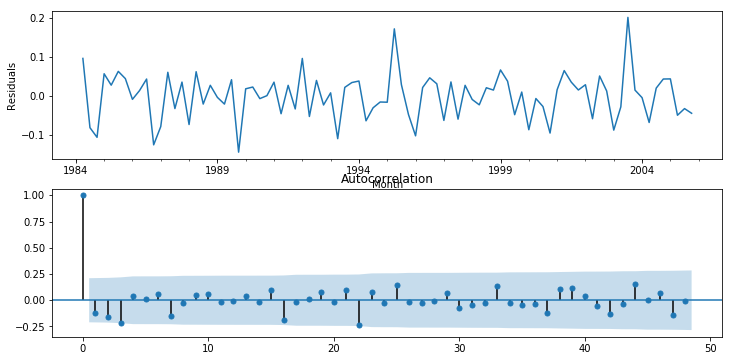

In [53]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's criterion: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

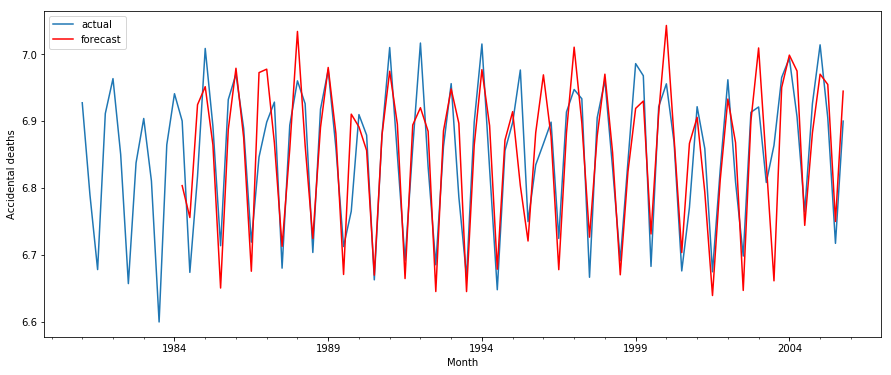

In [54]:
plt.figure(figsize=(15, 6))
df_log['Model'] = best_model.fittedvalues
df_log['Sales'].plot(label='actual')
df_log['Model'][13:].plot(color='r', label='forecast')
plt.ylabel('Accidental deaths')
plt.legend();

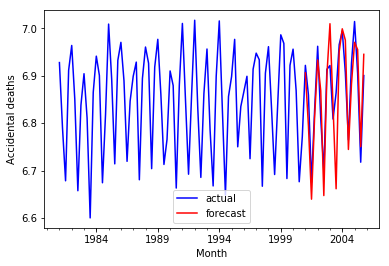

In [57]:
from dateutil.relativedelta import relativedelta
df3 = df_log[['Sales']]
date_list = [pd.datetime.strptime("2000-12-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,30)]
future = pd.DataFrame(index=date_list, columns=df2.columns)
df3 = pd.concat([df3, future])
df3['forecast'] = best_model.predict(start=80, end=100)

df_log['Sales'].plot(color='b', label='actual')
df3['forecast'].plot(color='r', label='forecast')
plt.ylabel('Accidental deaths')
plt.legend();

In [64]:
def mapee(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))* 100

mapee(df.Sales, df_log.Model)

99.27421292471548